# Trabalho Final

Alguns pontos essenciais da apresentação:

1. Apresentação da análise do Problema
2. Apresentação da análise e tratamento dos dados
3. Justificativa do uso de técnicas de IA para Resolução do problema
4. Justificativa da escolha do ambiente de desenvolvimento, teste e uso
5. Apresentação da metodologia da solução com uso de IA
6. Aplicação das técnicas de Inteligência Artificial no seu problema
7. Estratégias para obtenção de resultados melhores para solução do prooblema
8. Análise dos resultados            
9. Conclusões
10. Trabalhos futuros

Alguns critérios de Avaliações:

a) O problema ou dados foram analisados pensando-se na solução com uso de IA?
b) A solução apresentada tem fundamento? Justifica-se com os conceitos da IA?
c) A ambiente para desenvolvimento da solução faz uso das ferramentas atuais? Considera soluções atuais apresentadas pela comunidade científica e de desenvolvimento?
d) A solução apresentada buscou aproveitar, ao máximo, a técnica de IA? Houve preocupação em ajustar parâmetros para solução?
e) A análise foi feita de forma adequada?
f) Pensou em como seria o uso efetivo da sua solução?


## Bibliotecas

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 999)
pd.set_option("display.max_rows", 999)
np.set_printoptions(threshold=np.inf)

from PIL import Image, ImageFilter

import os, shutil
from pathlib import Path
import random

import tensorflow as tf 
from tensorflow import keras

from functools import partial


SEED = 42
np.random.seed(SEED)

BASE_PATH = Path.cwd().parent
PRE_PATH = BASE_PATH / 'data' / 'pre'

## Conexão Google Drive

In [ ]:
# # Mount Google Drive 
# from google.colab import drive
# drive.mount('/content/drive')

## Carregamento das imagens

In [ ]:
grid_map = {
    '64_32':64,
    '64_48':64,
    '128_64':128,
    '256_128':256
}

spatial_res_map = {
    '2m':2,
    '1m':1,
    '05m': 0.5
}

In [ ]:
def get_images(imgs_dir, imgs_names, img_size, crop_size):
    """
    Inputs:
        imgs_dir: path to the images directory
        imgs_names: list of images names
        img_size: size of the images
        crop_size: size of the crop
    Outputs:
        imgs_resized: list of images resized and cropped
    """
    img_shape = (img_size, img_size)
    crop_shape = (crop_size, crop_size, img_size-crop_size, img_size-crop_size)
    imgs = [Image.open(imgs_dir / img_name) for img_name in imgs_names]
    imgs_resized = [img.resize(img_shape).crop(crop_shape) for img in imgs]

    return imgs_resized

In [ ]:
def imgs_to_array(imgs):
    # print(imgs[:10])
    img_array = np.stack([np.asarray(img) for img in imgs], axis=0)
    # print(img_array.shape)
    return img_array

In [ ]:
def get_labels(spatial_res, grid, dataset, threshold=0.05, samples=None, positive_only=False, balance_classes=False):
    img_size = int(grid_map[grid] / spatial_res_map[spatial_res])
    crop_size = 1
    imgs_dir = Path(PRE_PATH, 'Labels', spatial_res, grid, dataset)
    imgs_names = [name for name in os.listdir(imgs_dir) if name[-3:] == 'jpg']
    imgs = get_images(imgs_dir, imgs_names, img_size, crop_size)
    imgs_array = imgs_to_array(imgs)
    labels = imgs_array.sum(axis=1).sum(axis=1) / (img_size^2) > threshold
    labels = labels.astype(int)
    
    if positive_only:
        pos_idx = np.where(labels >= 1)[0]
        imgs_names = [imgs_names[idx] for idx in pos_idx]
        labels = labels[pos_idx]
    
    if balance_classes:
        pos_idx = np.where(labels >= 1)[0]
        neg_idx = np.where(labels == 0)[0]
        pos_names = [imgs_names[idx] for idx in pos_idx]
        samples_neg = np.random.choice(np.arange(len(neg_idx)), size=len(pos_idx), replace=False)
        neg_names = [imgs_names[idx] for idx in samples_neg]
        imgs_names = pos_names + neg_names
        labels = np.concatenate([labels[pos_idx], labels[samples_neg]])

    if samples is not None:
        samples_idx = np.random.choice(np.arange(len(labels)), samples, replace=False)
        imgs_names = [imgs_names[idx] for idx in samples_idx]
        labels = labels[samples_idx]
        
    return imgs_names, labels

In [ ]:
def plot_images(spatial_res, grid, dataset, positive=True, samples=5, sources=None):
    names, labels = get_labels(spatial_res, grid, dataset, 0.05, samples, positive)
    img_size = int(grid_map[grid] / spatial_res_map[spatial_res])
    if sources == None:
        sources = ['CBERS_234', 'CBERS_321', 'CBERS_432', 'Labels', 'Google']

    src_imgs = []
    for source in sources:
        if source == 'Google':
            imgs = get_images(Path(PRE_PATH, source, '03m', grid, dataset), names, int(grid_map[grid] / 0.3), 2)
        else:
            imgs = get_images(Path(PRE_PATH, source, spatial_res, grid, dataset), names, img_size, 2)

        src_imgs.append(imgs)

    fig, axs = plt.subplots(len(src_imgs), samples, figsize=(12, samples*2.5))
    for i, imgs in zip(range(len(src_imgs)), src_imgs):
        for j in range(samples):
            axs[i, j].imshow(imgs[j])
            axs[i, j].title.set_text(names[j])
    plt.tight_layout()
    plt.show()
    return names, labels


In [ ]:
df = pd.DataFrame(columns=['spatial_res', 'grid', 'dataset', 'imgs', 'pos', '%pos'])

for spatial_res in ['2m']:
    for grid in ['64_48']:
        for dataset in ['Train', 'Test']:
            _, labels = get_labels(spatial_res, grid, dataset)
            df = pd.concat([df, 
                            pd.DataFrame({'spatial_res':[spatial_res],
                                          'grid':[grid],
                                          'dataset':[dataset],
                                          'imgs':[labels.shape[0]],
                                          'pos':[labels.sum()]},)], ignore_index=True)

df['%pos'] = df.pos / df.imgs    
df.head(100)

,spatial_res,grid,dataset,imgs,pos,%pos
0,2m,64_48,Train,2611,216,0.082727
1,2m,64_48,Test,556,91,0.163669


## Inspeção visual

### Dataset Treino - Amostras Positivas

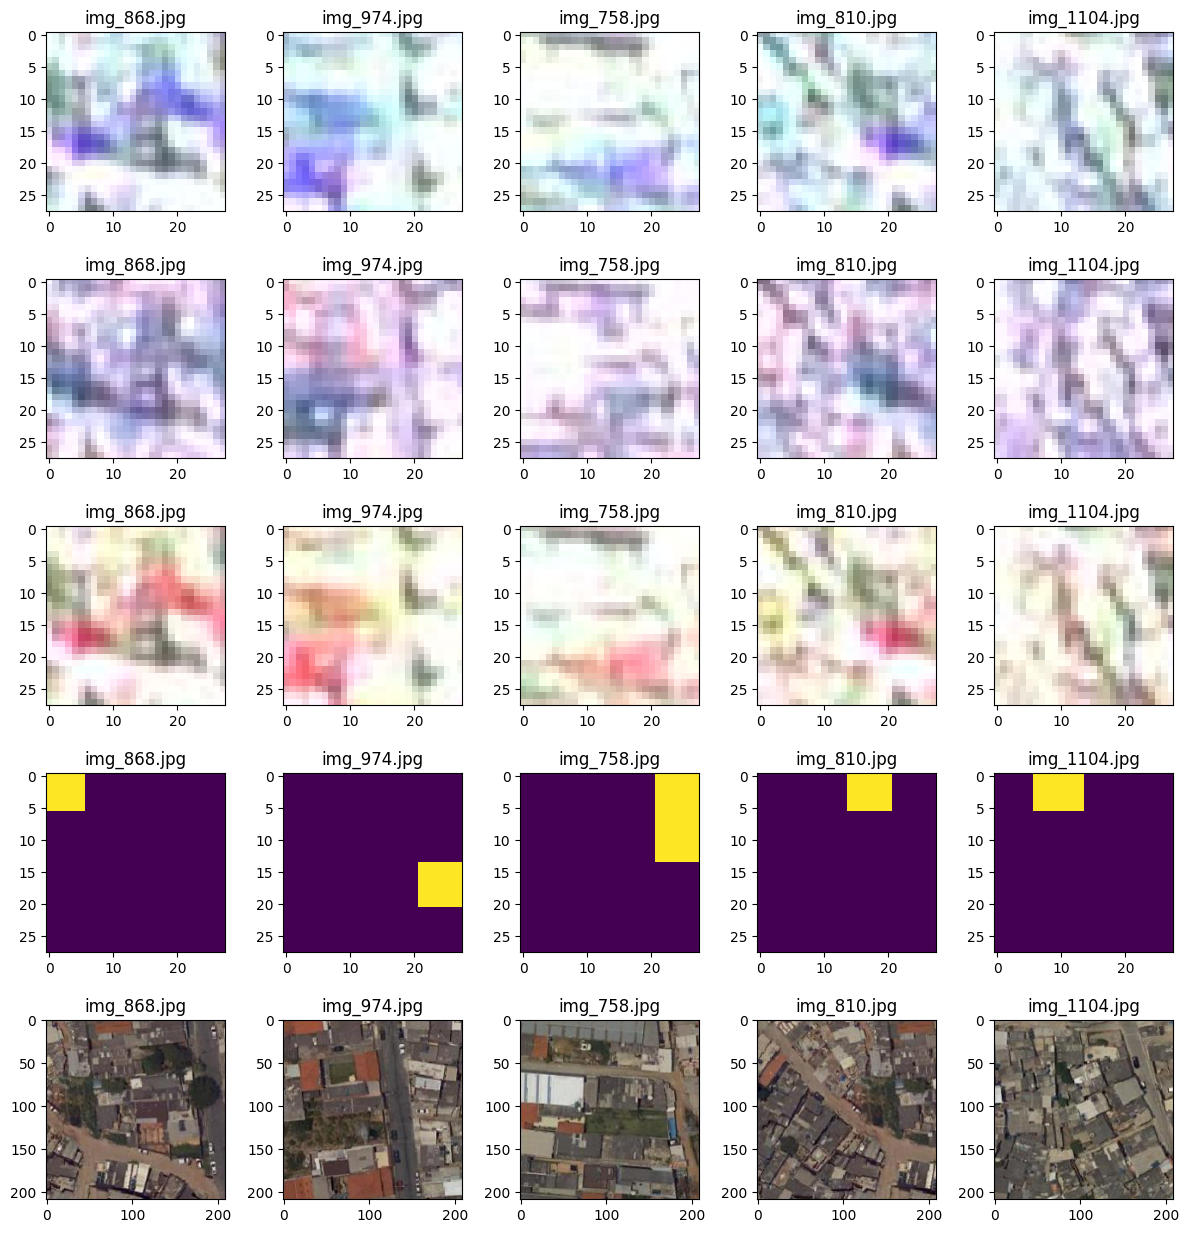

In [ ]:
names, labels = plot_images('2m', '64_48', 'Train')

### Dataset Treino - Amostras Negativas

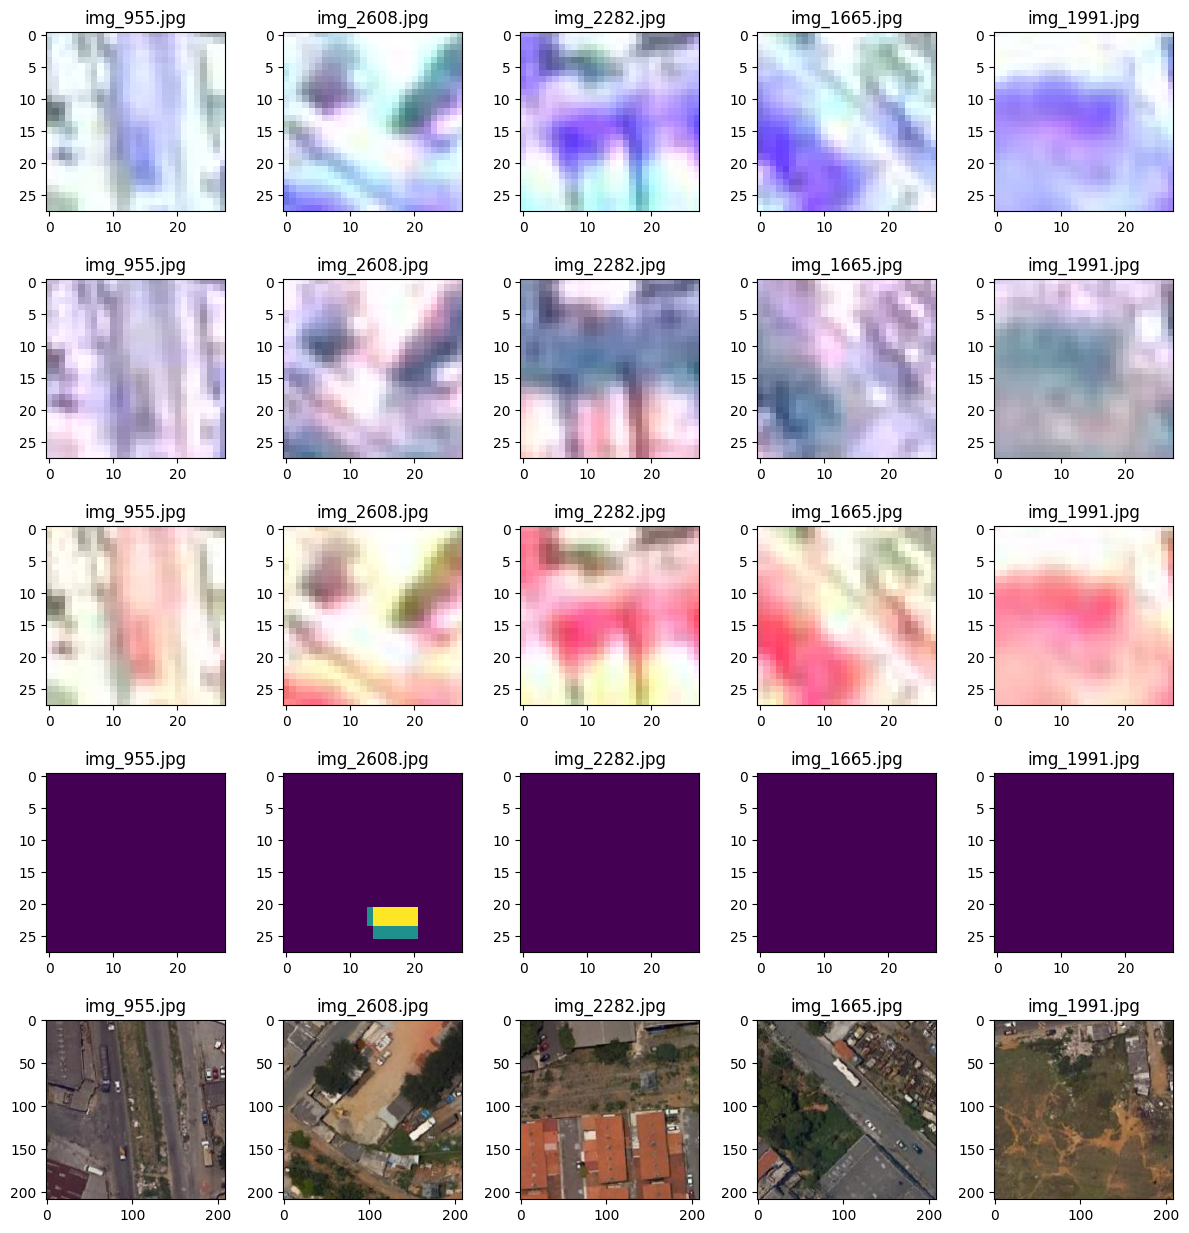

In [ ]:
names, labels = plot_images('2m', '64_48', 'Train', False, 5)

### Dataset Teste - Amostras Positivas

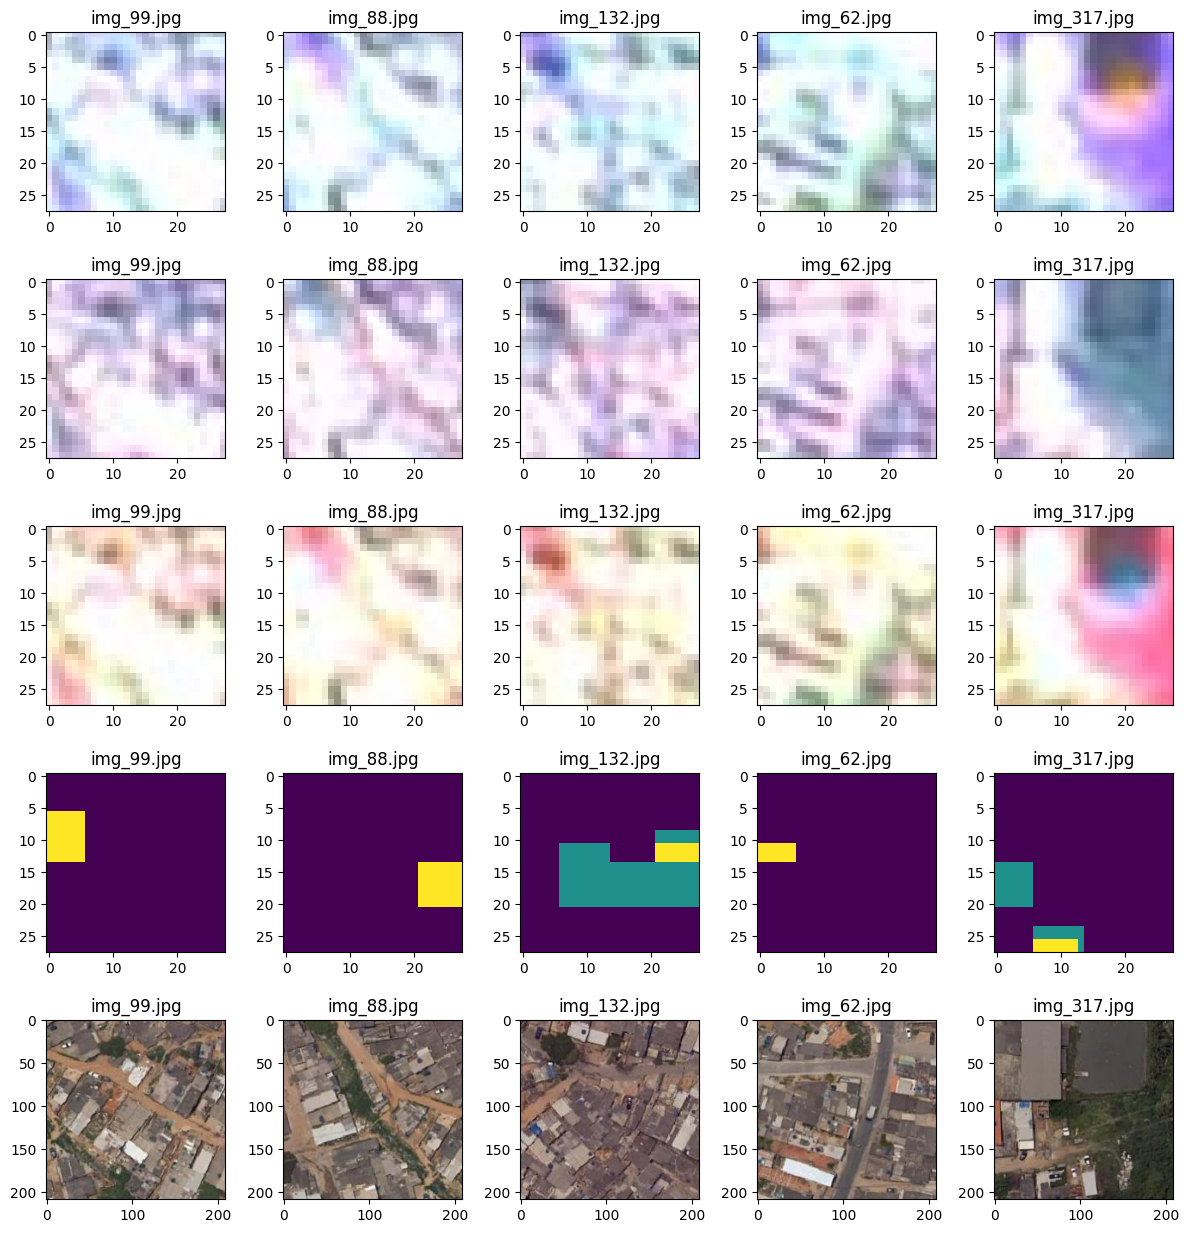

In [ ]:
names, labels = plot_images('2m', '64_48', 'Test')

### Dataset Teste - Amostras Negativas

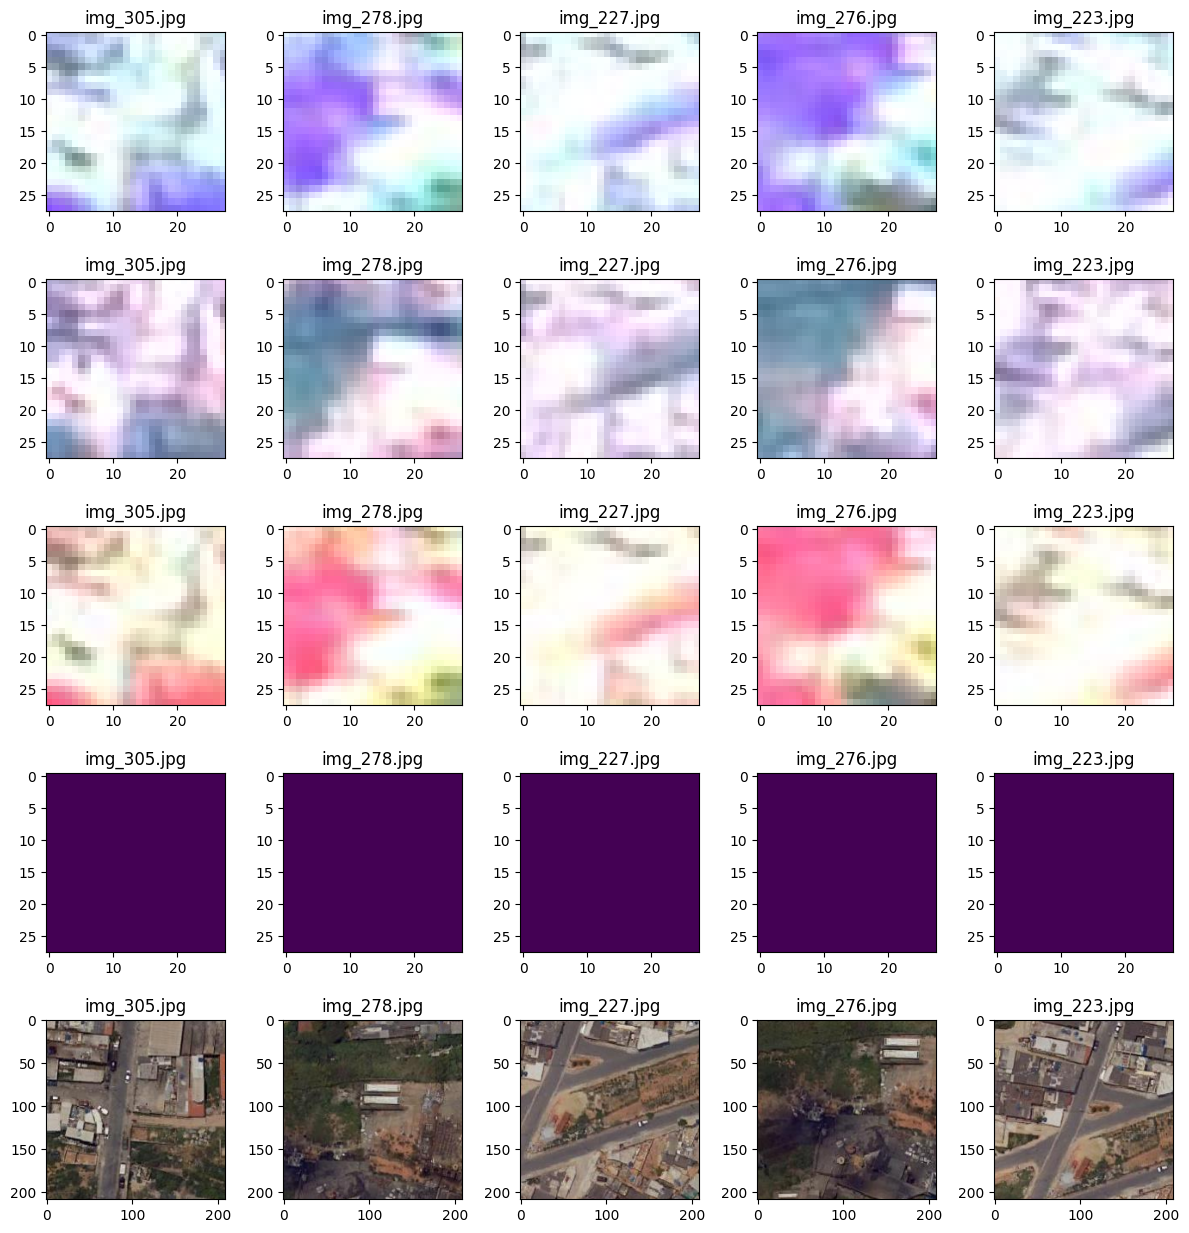

In [ ]:
names, labels = plot_images('2m', '64_48', 'Test', False, 5)

## Criando a Rede Neural Convolucional

In [ ]:
def build_model(size, arq='simple_cnn'):
    if arq=='simple_cnn':
        inputs = keras.Input(shape=(size, size, 3))
        x = keras.layers.Rescaling(1./255)(inputs)
        x = keras.layers.Conv2D(filters=2, kernel_size=3, activation="relu")(x)
        x = keras.layers.MaxPooling2D(pool_size=2)(x)
        x = keras.layers.Conv2D(filters=4, kernel_size=3, activation="relu")(x)
        x = keras.layers.MaxPooling2D(pool_size=2)(x)
        x = keras.layers.Conv2D(filters=8, kernel_size=3, activation="relu")(x)
        x = keras.layers.Flatten()(x)
        outputs = keras.layers.Dense(1, kernel_regularizer=keras.regularizers.l2(0.001), activation="sigmoid")(x)
        model = keras.Model(inputs=inputs, outputs=outputs)

    elif arq=='handson_ml2_chap_14':
        DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

        model = keras.models.Sequential([
            DefaultConv2D(filters=64, kernel_size=7, input_shape=[size, size, 3]),
            keras.layers.MaxPooling2D(pool_size=2),
            DefaultConv2D(filters=128),
            DefaultConv2D(filters=128),
            keras.layers.MaxPooling2D(pool_size=2),
            DefaultConv2D(filters=256),
            DefaultConv2D(filters=256),
            keras.layers.MaxPooling2D(pool_size=2),
            keras.layers.Flatten(),
            keras.layers.Dense(units=128, activation='relu'),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(units=64, activation='relu'),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(units=1, activation='sigmoid'), # adaptado de multi-label para classificação binária
        ])

    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model

## Preparando Dados de Treino e Teste

In [ ]:
def make_train_test(source, spatial_res, grid, only_train=False):
    img_size = int(grid_map[grid] / spatial_res_map[spatial_res])
    train_names, y_train = get_labels(spatial_res, grid, 'Train', 0.05, None, False, True)
    train_imgs = get_images(Path(PRE_PATH, source, spatial_res, grid, 'Train'), train_names, img_size, 1)
    X_train = imgs_to_array(train_imgs)

    if only_train == False:
        test_names, y_test = get_labels(spatial_res, grid, 'Test', 0.05, None, False, True)
        test_imgs = get_images(Path(PRE_PATH, source, spatial_res, grid, 'Test'), test_names, img_size, 1)
        X_test = imgs_to_array(test_imgs)
    else:
        y_test = None
        X_test = None
    
    return X_train, y_train, X_test, y_test

## Treinando o modelo com validação cruzada

In [ ]:
from sklearn.model_selection import StratifiedKFold

def train_model_kfold(source, spatial_res, grid, n_splits=5, num_epochs=100, batch_size=16, arq='simple_cnn'):
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    X_train, y_train, _, _ = make_train_test(source, spatial_res, grid, True)
    
    img_size = grid_map[grid] / spatial_res_map[spatial_res]
    img_size = int(img_size) - 2

    all_loss, all_val_loss, all_acc, all_val_acc = [], [], [], []
    fold = 0

    for train_idx, val_idx in kfold.split(X_train, y_train):
        
        X_train_fold = X_train[train_idx].copy()
        y_train_fold = y_train[train_idx].copy()
        
        X_val_fold = X_train[val_idx].copy()
        y_val_fold = y_train[val_idx].copy()
        
        model = build_model(img_size, arq)
        # model.summary()
        
        history = model.fit(X_train_fold, y_train_fold,
                            validation_data=(X_val_fold, y_val_fold),
                            epochs=num_epochs, batch_size=batch_size, verbose=0)
        
        # loss
        loss = history.history["loss"]
        val_loss = history.history["val_loss"]
        all_loss.append(loss)
        all_val_loss.append(val_loss)

        # accuracy
        acc = history.history["accuracy"]
        val_acc = history.history["val_accuracy"]
        all_acc.append(acc)
        all_val_acc.append(val_acc)

        print('Fold {}: Train Loss {:0.3f} | Train Acc {:0.3f}'.format(fold,
                                                                    loss[-1],
                                                                    acc[-1]))
        print('Fold {}: Val   Loss {:0.3f} | Val   Acc {:0.3f}'.format(fold,
                                                                    val_loss[-1],
                                                                    val_acc[-1]))
        fold += 1
        
    results = {
        'all_loss': all_loss,
        'all_val_loss': all_val_loss,
        'all_acc': all_acc,
        'all_val_acc': all_val_acc
    }
    return results

In [ ]:
def plot_results(results):
    all_loss = results['all_loss']
    all_val_loss = results['all_val_loss']
    all_acc = results['all_acc']
    all_val_acc = results['all_val_acc']

    num_epochs = len(all_loss[0])

    average_loss_history = [
        np.mean([x[i] for x in all_loss]) for i in range(num_epochs)]

    average_val_loss_history = [
        np.mean([x[i] for x in all_val_loss]) for i in range(num_epochs)]

    average_acc_history = [
        np.mean([x[i] for x in all_acc]) for i in range(num_epochs)]

    average_val_acc_history = [
        np.mean([x[i] for x in all_val_acc]) for i in range(num_epochs)]

    epochs = range(1, num_epochs + 1)
    plt.plot(epochs, average_loss_history, "bo", label="Training loss")
    plt.plot(epochs, average_val_loss_history, "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    print()
    plt.plot(epochs, average_acc_history, "bo", label="Training accuracy")
    plt.plot(epochs, average_val_acc_history, "b", label="Validation accuracy")
    plt.title("Training and validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, fbeta_score
from sklearn.metrics import classification_report, matthews_corrcoef, accuracy_score

def avalia_modelo(y, p, title):

    TN, FP, FN, TP = confusion_matrix(y, p).ravel()
    f1 = f1_score(y, p)
    f2 = fbeta_score(y, p, beta=2)
    MCC = matthews_corrcoef(y, p)
    acc = accuracy_score(y, p)
    print()
    print('#-----------------------------< ' + title + ' >-----------------------------#')
    print("n = {}\t\t\tPredicted Positive \tPredicted Negative".format(p.shape[0]))
    print("Actually Positive\t\t{} \t\t\t{}".format(TP, FN))
    print("Actually Negative\t\t{} \t\t\t{}".format(FP, TN))
    print()
    print('Acc', acc)
    print("f1", f1)
    print("f2", f2)
    print("MCC", MCC)
#     print("#-------------------------------------------------------------------------#")

    scores = {
        "TN":TN,
        "FP":FP,
        "FN":FN,
        "TP":TP,
        "f1":f1,
        "f2":f2,
        "MCC":MCC
    }
  
    return scores

In [ ]:
from sklearn.metrics import classification_report

def evaluate_model(source, spatial_res, grid, num_epochs=100, batch_size=16, arq='simple_cnn'):
    X_train, y_train, X_test, y_test = make_train_test(source, spatial_res, grid, False)
    img_size = grid_map[grid] / spatial_res_map[spatial_res]
    img_size = int(img_size) - 2

    model = build_model(img_size, arq)
    history = model.fit(X_train, y_train,
                        epochs=num_epochs, batch_size=batch_size, verbose=0)

    train_preds = np.round(model.predict(X_train), 0)
    test_preds = np.round(model.predict(X_test), 0)

    avalia_modelo(y_train, train_preds, 'Training')
    avalia_modelo(y_test, test_preds, 'Test')

    return history
    

In [ ]:
def complete_experiment(source, spatial_res, grid, num_epochs=100, batch_size=16, arq='simple_cnn'):
    results = train_model_kfold(source, spatial_res, grid, 5, num_epochs, batch_size, arq)
    plot_results(results)
    history = evaluate_model(source, spatial_res, grid, num_epochs, batch_size, arq)
    return results, history

## Experimentos - CBERS_234

Fold 0: Train Loss 0.458 | Train Acc 0.806
Fold 0: Val   Loss 0.495 | Val   Acc 0.759
Fold 1: Train Loss 0.410 | Train Acc 0.835
Fold 1: Val   Loss 0.482 | Val   Acc 0.782
Fold 2: Train Loss 0.376 | Train Acc 0.847
Fold 2: Val   Loss 0.396 | Val   Acc 0.860
Fold 3: Train Loss 0.421 | Train Acc 0.832
Fold 3: Val   Loss 0.551 | Val   Acc 0.744
Fold 4: Train Loss 0.430 | Train Acc 0.815
Fold 4: Val   Loss 0.479 | Val   Acc 0.779


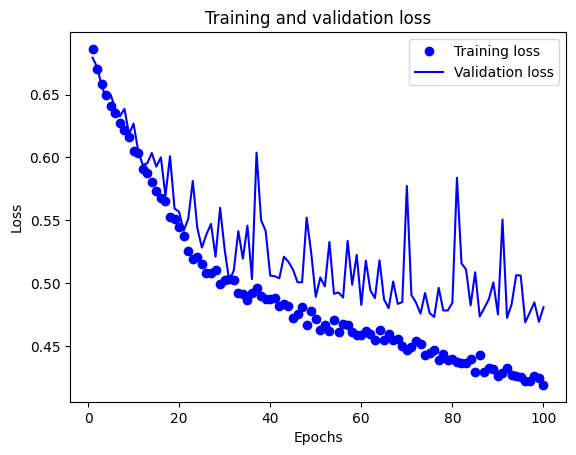

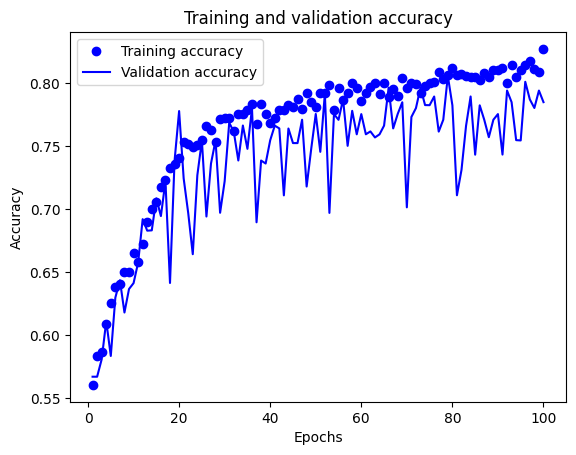

6/6 [==============================] - 0s 3ms/step

#-----------------------------< Training >-----------------------------#
n = 432			Predicted Positive 	Predicted Negative
Actually Positive		217 			12
Actually Negative		70 			133

Acc 0.8101851851851852
f1 0.8410852713178294
f2 0.9019118869492935
MCC 0.6370784584328434

#-----------------------------< Test >-----------------------------#
n = 182			Predicted Positive 	Predicted Negative
Actually Positive		88 			18
Actually Negative		34 			42

Acc 0.7142857142857143
f1 0.7719298245614035
f2 0.8058608058608058
MCC 0.40160498975475933


({'all_loss': [[0.6925491690635681,
    0.6895596981048584,
    0.6886202692985535,
    0.6869972944259644,
    0.6864638328552246,
    0.6841766238212585,
    0.6819391250610352,
    0.6801837682723999,
    0.6785805225372314,
    0.6740492582321167,
    0.6709218621253967,
    0.6635819673538208,
    0.6592753529548645,
    0.6483559608459473,
    0.6412991881370544,
    0.6278190612792969,
    0.6181454658508301,
    0.6076295971870422,
    0.6030896902084351,
    0.5888730883598328,
    0.5862743258476257,
    0.564644992351532,
    0.5535107851028442,
    0.549302339553833,
    0.5355470776557922,
    0.5422986745834351,
    0.5337458848953247,
    0.5272711515426636,
    0.5222374796867371,
    0.5344181060791016,
    0.5280070304870605,
    0.5189378261566162,
    0.5243578553199768,
    0.49784529209136963,
    0.5017921328544617,
    0.510913074016571,
    0.5075511932373047,
    0.5169287323951721,
    0.5036438703536987,
    0.5147349238395691,
    0.5076255798339844,
    0.

In [ ]:
_, _ = complete_experiment('CBERS_234', '2m', '64_48')

## Experimentos - CBERS_321

Fold 0: Train Loss 0.689 | Train Acc 0.545
Fold 0: Val   Loss 0.688 | Val   Acc 0.552
Fold 1: Train Loss 0.457 | Train Acc 0.797
Fold 1: Val   Loss 0.546 | Val   Acc 0.713
Fold 2: Train Loss 0.455 | Train Acc 0.786
Fold 2: Val   Loss 0.452 | Val   Acc 0.791
Fold 3: Train Loss 0.383 | Train Acc 0.824
Fold 3: Val   Loss 0.469 | Val   Acc 0.791
Fold 4: Train Loss 0.392 | Train Acc 0.844
Fold 4: Val   Loss 0.417 | Val   Acc 0.837


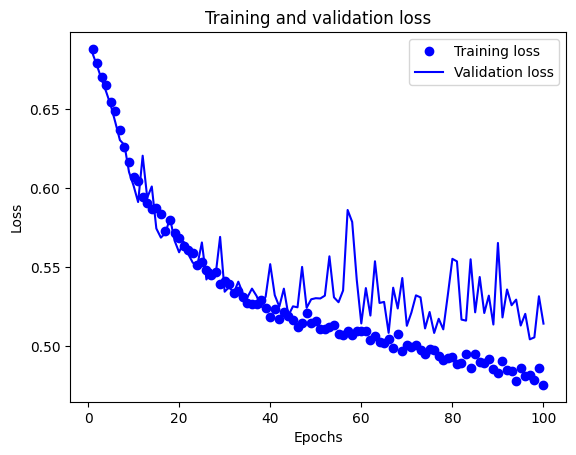

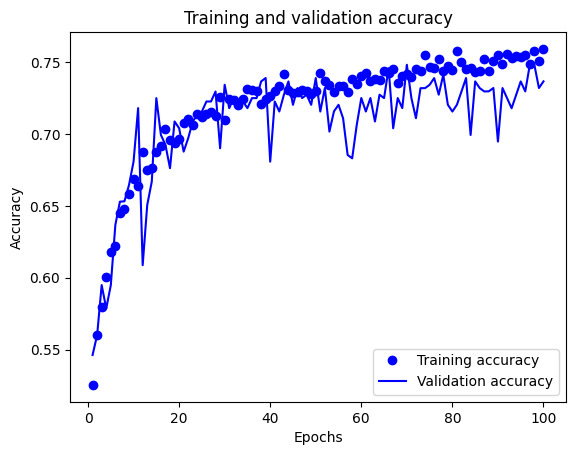

6/6 [==============================] - 0s 6ms/step

#-----------------------------< Training >-----------------------------#
n = 432			Predicted Positive 	Predicted Negative
Actually Positive		232 			0
Actually Negative		200 			0

Acc 0.5370370370370371
f1 0.6987951807228916
f2 0.8529411764705883
MCC 0.0

#-----------------------------< Test >-----------------------------#
n = 182			Predicted Positive 	Predicted Negative
Actually Positive		104 			0
Actually Negative		78 			0

Acc 0.5714285714285714
f1 0.7272727272727273
f2 0.8695652173913042
MCC 0.0


In [ ]:
_, _ = complete_experiment('CBERS_321', '2m', '64_48')

## Experimentos - CBERS_432

Fold 0: Train Loss 0.424 | Train Acc 0.809
Fold 0: Val   Loss 0.607 | Val   Acc 0.713
Fold 1: Train Loss 0.436 | Train Acc 0.788
Fold 1: Val   Loss 0.507 | Val   Acc 0.770
Fold 2: Train Loss 0.456 | Train Acc 0.775
Fold 2: Val   Loss 0.523 | Val   Acc 0.779
Fold 3: Train Loss 0.466 | Train Acc 0.772
Fold 3: Val   Loss 0.464 | Val   Acc 0.802
Fold 4: Train Loss 0.463 | Train Acc 0.780
Fold 4: Val   Loss 0.487 | Val   Acc 0.756


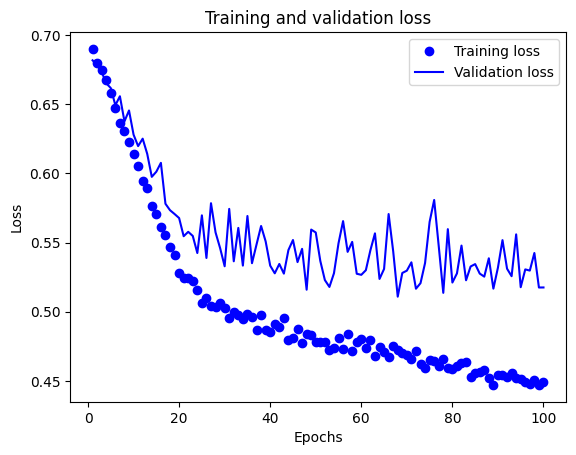

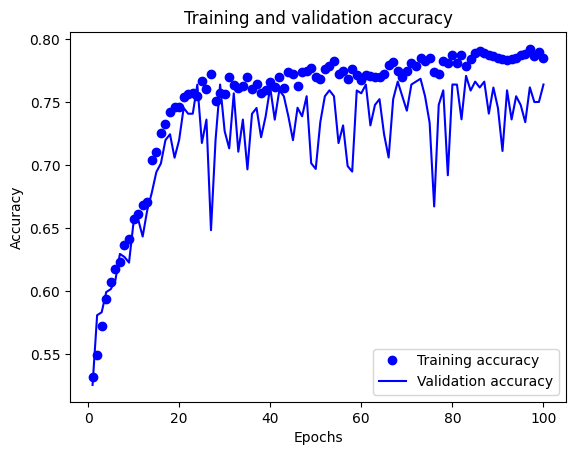

6/6 [==============================] - 0s 4ms/step

#-----------------------------< Training >-----------------------------#
n = 432			Predicted Positive 	Predicted Negative
Actually Positive		226 			7
Actually Negative		85 			114

Acc 0.7870370370370371
f1 0.8308823529411764
f2 0.9090909090909091
MCC 0.6025437449480555

#-----------------------------< Test >-----------------------------#
n = 182			Predicted Positive 	Predicted Negative
Actually Positive		97 			11
Actually Negative		32 			42

Acc 0.7637362637362637
f1 0.8185654008438819
f2 0.8645276292335117
MCC 0.5035189747070061


In [ ]:
_, _ = complete_experiment('CBERS_432', '2m', '64_48')

## Experimentos - Google 2m

Fold 0: Train Loss 0.429 | Train Acc 0.803
Fold 0: Val   Loss 0.460 | Val   Acc 0.782
Fold 1: Train Loss 0.486 | Train Acc 0.751
Fold 1: Val   Loss 0.555 | Val   Acc 0.736
Fold 2: Train Loss 0.395 | Train Acc 0.827
Fold 2: Val   Loss 0.509 | Val   Acc 0.733
Fold 3: Train Loss 0.414 | Train Acc 0.801
Fold 3: Val   Loss 0.407 | Val   Acc 0.826
Fold 4: Train Loss 0.449 | Train Acc 0.795
Fold 4: Val   Loss 0.537 | Val   Acc 0.767


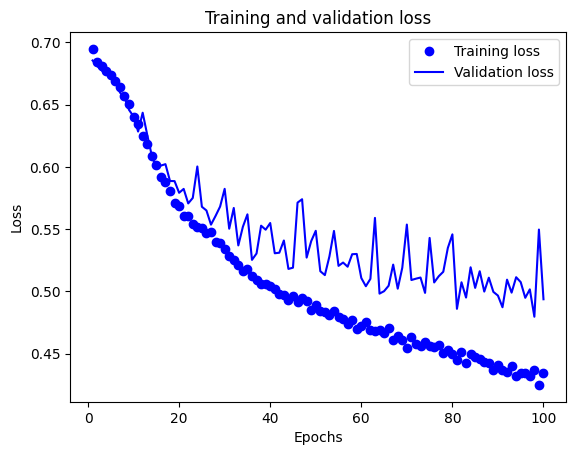

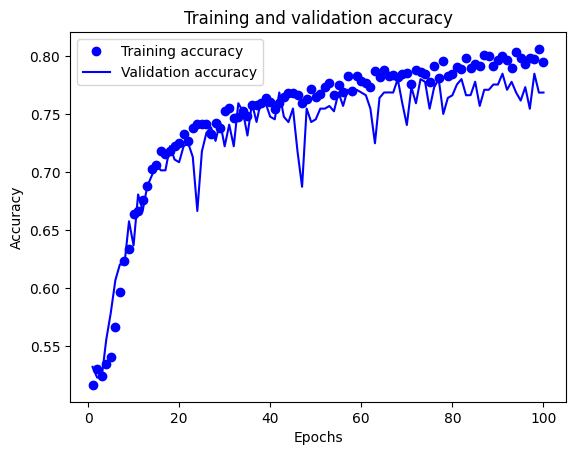

6/6 [==============================] - 0s 5ms/step

#-----------------------------< Training >-----------------------------#
n = 432			Predicted Positive 	Predicted Negative
Actually Positive		215 			18
Actually Negative		68 			131

Acc 0.8009259259259259
f1 0.8333333333333334
f2 0.8847736625514403
MCC 0.6092883317660334

#-----------------------------< Test >-----------------------------#
n = 182			Predicted Positive 	Predicted Negative
Actually Positive		88 			17
Actually Negative		42 			35

Acc 0.6758241758241759
f1 0.748936170212766
f2 0.8000000000000002
MCC 0.3200378765462651


In [ ]:
_, _ = complete_experiment('Google', '2m', '64_48')

## Experimentos - Google 0,5m

In [ ]:
# _, _ = complete_experiment('Google', '05m', '64_48')

FileNotFoundError: [WinError 3] O sistema não pode encontrar o caminho especificado: 'c:\\github\\cm203\\data\\pre\\Labels\\05m\\64_48\\Train'

## Experimentos - Nova Arquitetura

In [ ]:
_, _ = complete_experiment('CBERS_234', '2m', '64_48', arq='handson_ml2_chap_14')


Fold 0: Train Loss 0.001 | Train Acc 1.000
Fold 0: Val   Loss 1.598 | Val   Acc 0.839


KeyboardInterrupt: 